In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations

from typing import *  # pyright: ignore
from decimal import Decimal
from fractions import Fraction

import numpy as np
from numpy.typing import NDArray as _NDArray

_T = TypeVar("_T", bound=Any)
NDArray: TypeAlias = _NDArray[_T]
NestedSequence: TypeAlias = "Sequence[_T | NestedSequence[_T]]"

Scalar: TypeAlias = float | int | Decimal | Fraction | np.number[Any]
ScalarT = TypeVar("ScalarT", bound=Scalar)


ArrayLike: TypeAlias = "NDArray[ScalarT] | NestedSequence[ScalarT]"

In [3]:
import metpy.units
import metpy.calc

import pint
from pint.registry import Quantity, Unit
from pint.facets.plain import PlainQuantity, PlainUnit


if TYPE_CHECKING:
    from literal_unit import LiteralUnit  # pyright: ignore
else:
    LiteralUnit = str

In [44]:
import pint.registry


ureg = pint.UnitRegistry()


def unit(x: Any) -> Unit:
    x = ureg.Unit(x)
    assert isinstance(x, Unit)
    return x
dimensionless = unit("dimensionless")


# ureg = pint.registry.GenericUnitRegistry()
ureg.default_format = ".3f~P"

# • [time]
s = unit("second")
min_ = unit("minute")
hr = unit("hour")


# • [temperature]
K = unit("kelvin")
C = unit("celsius")
F = unit("fahrenheit")


# • [length]
m = unit("meter")
km = unit("kilometer")

in_ = unit("inch")
ft = unit("foot")
mi = unit("mile")


# • pressure
Pa = unit("pascal")
hPa = unit("hectopascal")
kPa = unit("kilopascal")
mbar = unit("millibar")

# • energy
J = unit("joule")
kJ = unit("kilojoule")
cal = unit("calorie")
kcal = unit("kilocalorie")
mol = unit("mole")

# - [mass]
kg = unit("kilogram")


# - angle
deg = unit("degree")
rad = unit("radian")


# - speed
mps = m / s
kph = km / hr
mph = mi / hr
kts = unit("knot")

# - image processing
px = unit("pixel")
dpi = unit("dot/inch")
ppi = unit(px / in_)

In [43]:
unit(str(px / ppi)), ppi,
ppi = unit(px / ureg.inch)
assert isinstance(ppi, Unit)
ppi

<Unit('pixel / inch')>

In [5]:
from src.mesoformer.utils import as_any_array


def unit(x: Any):
    return ureg(x).units


def isscaler(x: Any) -> TypeGuard[Scalar]:
    return np.isscalar(x.magnitude if isinstance(x, Quantity) else x)


@overload
def quantity(
    x: ScalarT,
    unit: pint.Unit | Quantity | LiteralUnit | PlainUnit | PlainQuantity = dimensionless,
) -> PlainQuantity[ScalarT]:
    ...


@overload
def quantity(
    x: ArrayLike[ScalarT],
    unit: pint.Unit | Quantity | LiteralUnit | PlainUnit | PlainQuantity = dimensionless,
) -> PlainQuantity[NDArray[ScalarT]]:  # type: ignore
    ...


def quantity(
    x: ScalarT | ArrayLike[ScalarT],
    unit: pint.Unit | Quantity | LiteralUnit | PlainUnit | PlainQuantity = dimensionless,
) -> PlainQuantity[ScalarT] | PlainQuantity[NDArray[ScalarT]]:  # type: ignore
    unit = ureg(unit) if isinstance(unit, str) else unit
    return (x if isscaler(x) else np.asanyarray(x)) * unit  # type: ignore


@as_any_array(np.float32)
def normalize(x: NDArray[np.number]) -> NDArray[np.float_]:
    return (x - x.min(keepdims=True)) / (x.max(keepdims=True) - x.min(keepdims=True))


@ureg.wraps(dimensionless, hPa)
def log_p(x) -> Quantity:
    return np.log(x)


@ureg.wraps(dimensionless, hPa)
def exp_p(x) -> Quantity:
    return np.exp(x)

In [6]:
EARTH_GRAVITY = g = quantity(9.80665, m / s**2)
""">>> EARTH_GRAVITY `little g`"""
GRAVITATIONAL_CONSTANT = G = quantity(6.67408e-11, m**3 / kg / s**2)
"""`big G`""" ""
EARTH_RADIUS = Re = quantity(6371008.7714, m)
GEOCENTRIC_GRAVITATIONAL_CONSTANT = GM = quantity(3986005e8, m**3 / s**2)
EARTH_MASS = Me = GEOCENTRIC_GRAVITATIONAL_CONSTANT / GRAVITATIONAL_CONSTANT


ABSOLUTE_ZERO = K0 = quantity(-273.15, K)
MOLAR_GAS_CONSTANT = R = quantity(8.314462618, J / mol / K)


STANDARD_TEMPERATURE = t0 = quantity(288.0, K)
"""Standard temperature at sea level."""
STANDARD_PRESSURE = p0 = quantity(1013.25, hPa)
"""Standard pressure at sea level."""
STANDARD_LAPSE_RATE = gamma = quantity(6.5, K / km)
"""Standard lapse rate."""

MOLAR_GAS_CONSTANT = R = quantity(8.314462618, J / mol / K)
DRY_AIR_MOLECULAR_WEIGHT_RATIO = Md = quantity(28.96546e-3, kg / mol)

# Dry air

DRY_AIR_GAS_CONST = Rd = quantity(R / Md)
# Md = dry_air_molecular_weight = units.Quantity(28.96546e-3, 'kg / mol')
# Rd = dry_air_gas_constant = R / Md
DRY_AIR_SPECIFIC_HEAT_RATIO = dash_r = quantity(1.4)
DRY_AIR_SPECIFIC_HEAT_PRESSURE = Cp_d = quantity(dash_r * Rd / (dash_r - 1))
DRY_AIR_SPECIFIC_HEAT_VOLUME = Cv_d = quantity(Cp_d / dash_r)
P0 = pot_temp_ref_press = 1000.0 * mbar
DRY_AIR_DENSITY_STP = rho_d = quantity(P0 / (Rd * -K0)).to(kg / m**3)
# rho_d = dry_air_density_stp = quantity(P0 / (Rd * -K0)).to("kg / m^3")
# Dry air
DRY_AIR_MOLECULAR_WEIGHT_RATIO = Md = 28.96546e-3 * kg / mol
DRY_AIR_GAS_CONST = Rd = R / Md
# Md = dry_air_molecular_weight = units.Quantity(28.96546e-3, 'kg / mol')
# Rd = dry_air_gas_constant = R / Md
# dry_air_spec_heat_ratio = 1.4 * dimensionless
# Cp_d = dry_air_spec_heat_press = dry_air_spec_heat_ratio * Rd / (dry_air_spec_heat_ratio - 1)
# Cv_d = dry_air_spec_heat_vol = Cp_d / dry_air_spec_heat_ratio
# P0 = pot_temp_ref_press = 1000.0 * mbar
# rho_d = dry_air_density_stp = quantity(P0 / (Rd * -K0)).to(kg / m**3)
# Cp_d, Cv_d, _CP, Cv_d / Cp_d

In [7]:
from numbers import Number


def pressure2height(pressure: PlainQuantity[NDArray[Any]]) -> PlainQuantity[float]:
    return t0 / gamma * (1 - (pressure / p0) ** (Rd * gamma / g))


def height2pressure(height: PlainQuantity[float | int] | NDArray) -> PlainQuantity[float]:
    return p0 * (1 - (gamma / t0) * height) ** (g / (Rd * gamma))


STANDARD_ATMOSPHERE = p_levels = [1013.25, *map(float, range(1000, 25 - 11, -25))]
# levels = [850.0, 700.0, 500.0, 300.0]
assert np.all(pressure2height(p_levels * hPa) == metpy.calc.pressure_to_height_std(p_levels * metpy.units.units.hPa))

heights = pressure2height(p_levels * hPa)
assert np.all(
    metpy.calc.height_to_pressure_std(metpy.calc.pressure_to_height_std(p_levels * metpy.units.units.hPa))
    == height2pressure(pressure2height(p_levels * hPa))
)

In [8]:
import matplotlib.pyplot as plt

p_levels = quantity([1013.25, *map(float, range(1000, 25 - 11, -25))], unit=hPa)
p_levels

Magnitude,[1013.25 1000.0 975.0 950.0 925.0 900.0 875.0 850.0 825.0 800.0 775.0 750.0 725.0 700.0 675.0 650.0 625.0 600.0 575.0 550.0 525.0 500.0 475.0 450.0 425.0 400.0 375.0 350.0 325.0 300.0 275.0 250.0 225.0 200.0 175.0 150.0 125.0 100.0 75.0 50.0 25.0]
Units,hPa


In [9]:
p_heights = pressure2height(p_levels)
p_heights

Magnitude,[-0.0 0.11082463191827029 0.3232070008045167 0.5400457639046174 0.7615554828072778 0.9879671974242984 1.2195301902939262 1.4565139962849931 1.6992107001633152 1.947937573358983 2.2030401123457213 2.464895554945448 2.7339169684442477 3.010558025783667 3.2953186148078832 3.588751462706507 3.891470006302654 4.204157802769398 4.527579860480632 4.862596384290676 5.21017958563185 5.571434423209202 5.947624441471662 6.340204302290991 6.7508612240611585 7.181568453172953 7.634655260977472 8.112900062019325 8.619656564404572 9.159028242671463 9.736115444461602 10.357375151717509 11.031162002595584 11.768573960438642 12.58483772014436 13.501714709781766 14.55200350500616 15.788845929720818 17.307853736092145 19.312405402539174 22.400622183232443]
Units,km


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

ureg.setup_matplotlib()
plot_kwargs: dict[str, Any] = dict(linestyle="-", linewidth=0.75, marker=".")


def plot_over_y(y: Any, x_dict: dict[str, Any], ax=None, **kwargs):
    ax = ax or plt.gca()
    legends = list(x_dict.keys())
    for key in legends:
        ax.plot(y, np.asanyarray(x_dict[key]), label=key, **(kwargs | plot_kwargs))

    ax.legend()

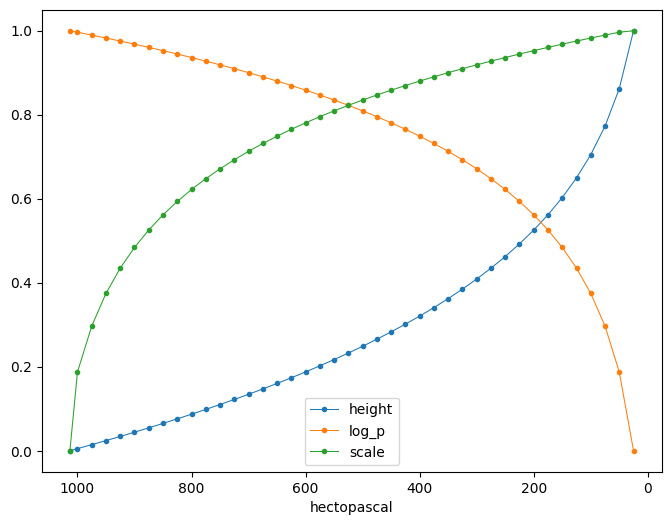

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.invert_xaxis()

norm_data = {
    "height": normalize(p_heights),
    "log_p": normalize(log_p(p_levels)),
    "scale": normalize(log_p(p_levels))[::-1],  # type: ignore
}
plot_over_y(p_levels, norm_data)


plt.show()

In [12]:
p_targets = quantity([1013.25, 850, 700, 500, 300], hPa)
mask = np.isin(p_levels, p_targets)  # type: ignore
x = normalize(log_p(p_levels))
x, x % 1

(array([1.        , 0.99644434, 0.98960555, 0.98258895, 0.9753853 ,
        0.96798426, 0.96037465, 0.95254457, 0.94448066, 0.93616855,
        0.9275926 , 0.9187354 , 0.9095778 , 0.90009886, 0.89027524,
        0.8800808 , 0.86948645, 0.8584596 , 0.8469633 , 0.834956  ,
        0.82238984, 0.80921066, 0.79535526, 0.7807506 , 0.7653108 ,
        0.74893486, 0.73150164, 0.7128652 , 0.69284713, 0.67122585,
        0.64772224, 0.621977  , 0.5935168 , 0.5617011 , 0.5256314 ,
        0.48399213, 0.43474323, 0.37446743, 0.2967584 , 0.18723372,
        0.        ], dtype=float32),
 array([0.        , 0.99644434, 0.98960555, 0.98258895, 0.9753853 ,
        0.96798426, 0.96037465, 0.95254457, 0.94448066, 0.93616855,
        0.9275926 , 0.9187354 , 0.9095778 , 0.90009886, 0.89027524,
        0.8800808 , 0.86948645, 0.8584596 , 0.8469633 , 0.834956  ,
        0.82238984, 0.80921066, 0.79535526, 0.7807506 , 0.7653108 ,
        0.74893486, 0.73150164, 0.7128652 , 0.69284713, 0.67122585,
        0.6

In [13]:
log_p(p_levels)

Magnitude,[6.920918265508418 6.907755278982137 6.882437470997847 6.856461984594587 6.829793737512425 6.802394763324311 6.774223886357614 6.745236349484363 6.715383386334681 6.684611727667927 6.652863029353347 6.620073206530356 6.586171654854675 6.551080335043404 6.51471269087253 6.476972362889683 6.437751649736401 6.396929655216146 6.354370040797351 6.309918278226516 6.263398262591624 6.214608098422191 6.163314804034641 6.1092475827643655 6.052089168924417 5.991464547107982 5.926926025970411 5.857933154483459 5.783825182329737 5.703782474656201 5.616771097666572 5.521460917862246 5.41610040220442 5.298317366548036 5.1647859739235145 5.0106352940962555 4.8283137373023015 4.605170185988092 4.31748811353631 3.912023005428146 3.2188758248682006]
Units,


In [14]:
p_levels

Magnitude,[1013.25 1000.0 975.0 950.0 925.0 900.0 875.0 850.0 825.0 800.0 775.0 750.0 725.0 700.0 675.0 650.0 625.0 600.0 575.0 550.0 525.0 500.0 475.0 450.0 425.0 400.0 375.0 350.0 325.0 300.0 275.0 250.0 225.0 200.0 175.0 150.0 125.0 100.0 75.0 50.0 25.0]
Units,hPa


In [15]:
pressure2height(p_levels)

Magnitude,[-0.0 0.11082463191827029 0.3232070008045167 0.5400457639046174 0.7615554828072778 0.9879671974242984 1.2195301902939262 1.4565139962849931 1.6992107001633152 1.947937573358983 2.2030401123457213 2.464895554945448 2.7339169684442477 3.010558025783667 3.2953186148078832 3.588751462706507 3.891470006302654 4.204157802769398 4.527579860480632 4.862596384290676 5.21017958563185 5.571434423209202 5.947624441471662 6.340204302290991 6.7508612240611585 7.181568453172953 7.634655260977472 8.112900062019325 8.619656564404572 9.159028242671463 9.736115444461602 10.357375151717509 11.031162002595584 11.768573960438642 12.58483772014436 13.501714709781766 14.55200350500616 15.788845929720818 17.307853736092145 19.312405402539174 22.400622183232443]
Units,km


In [16]:
logh = np.log(pressure2height(p_levels).m + 1)
(normalize(logh * 30) + 1) * 30

array([30.      , 31.0001  , 32.664886, 34.108894, 35.387627, 36.538197,
       37.58664 , 38.55196 , 39.44847 , 40.287224, 41.076954, 41.8247  ,
       42.536224, 43.216316, 43.869034, 44.497837, 45.105732, 45.69536 ,
       46.269066, 46.82898 , 47.377045, 47.91507 , 48.44477 , 48.96781 ,
       49.485806, 50.000404, 50.513283, 51.026237, 51.541187, 52.060295,
       52.58603 , 53.121315, 53.669716, 54.23576 , 54.82541 , 55.446888,
       56.112236, 56.840412, 57.664597, 58.653267, 60.      ],
      dtype=float32)

In [17]:
log_p(p_levels).magnitude

array([6.92091827, 6.90775528, 6.88243747, 6.85646198, 6.82979374,
       6.80239476, 6.77422389, 6.74523635, 6.71538339, 6.68461173,
       6.65286303, 6.62007321, 6.58617165, 6.55108034, 6.51471269,
       6.47697236, 6.43775165, 6.39692966, 6.35437004, 6.30991828,
       6.26339826, 6.2146081 , 6.1633148 , 6.10924758, 6.05208917,
       5.99146455, 5.92692603, 5.85793315, 5.78382518, 5.70378247,
       5.6167711 , 5.52146092, 5.4161004 , 5.29831737, 5.16478597,
       5.01063529, 4.82831374, 4.60517019, 4.31748811, 3.91202301,
       3.21887582])

In [18]:
def create_scale(scale: NDArray[float], value: float = 1.0, ratio: float = 1.0):
    return ((normalize(scale) * ratio) + 1) * value


create_scale(log_p(p_levels).magnitude, value=1.0, ratio=1.0)[::-1]


def create_scale2(scale: NDArray[float], value: float = 1.0, ratio: float = 1.0):
    return normalize(value / scale) + 1


create_scale(log_p(p_levels).magnitude, value=1.0, ratio=1.0)[::-1], create_scale2(log_p(p_levels).m, value=30)

(array([1.       , 1.1872337, 1.2967584, 1.3744674, 1.4347432, 1.4839921,
        1.5256314, 1.561701 , 1.5935168, 1.621977 , 1.6477222, 1.6712258,
        1.6928471, 1.7128651, 1.7315016, 1.7489349, 1.7653108, 1.7807505,
        1.7953553, 1.8092107, 1.8223898, 1.8349559, 1.8469633, 1.8584596,
        1.8694865, 1.8800808, 1.8902752, 1.9000988, 1.9095778, 1.9187354,
        1.9275925, 1.9361686, 1.9444807, 1.9525446, 1.9603746, 1.9679842,
        1.9753853, 1.982589 , 1.9896055, 1.9964443, 2.       ],
       dtype=float32),
 array([1.       , 1.0016568, 1.0048615, 1.0081738, 1.0116009, 1.0151497,
        1.0188286, 1.0226461, 1.026612 , 1.0307372, 1.0350331, 1.0395132,
        1.0441923, 1.0490865, 1.0542142, 1.0595964, 1.0652568, 1.0712218,
        1.0775224, 1.0841938, 1.091277 , 1.09882  , 1.1068785, 1.1155194,
        1.1248221, 1.1348832, 1.1458198, 1.1577777, 1.1709399, 1.1855406,
        1.2018844, 1.2203782, 1.2415795, 1.2662787, 1.2956431, 1.3314879,
        1.3768378, 1.4372

URMA_GRID_SPACING = 2.5 km/pixel
ERA5_GRID_SPACING = 30.0 km/pixel


,scale,extent
300.00,30.062061,2404.964844
500.00,27.548679,2203.894531
700.00,23.885956,1910.876465
850.00,19.351034,1548.082764
1013.25,2.500000,200.000000


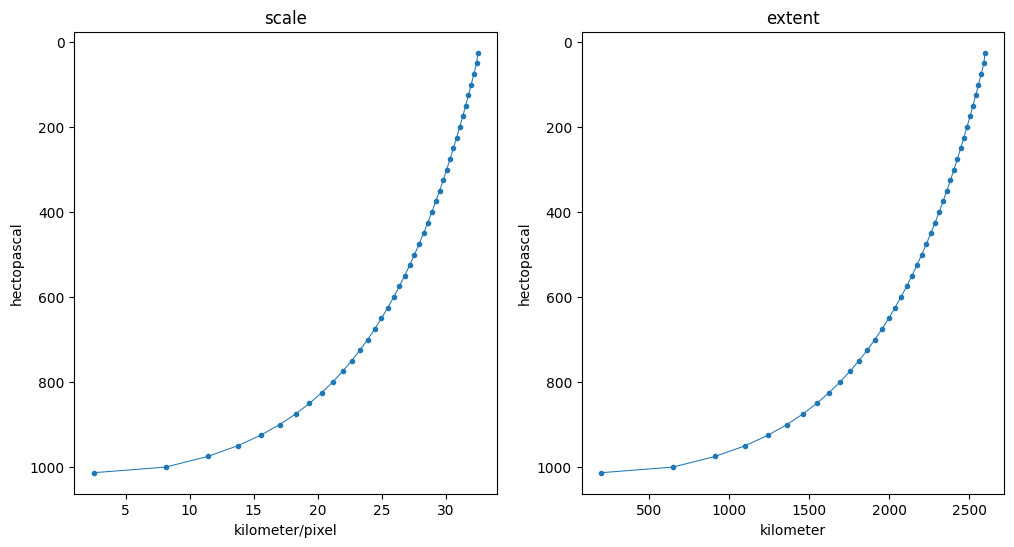

In [19]:
URMA_GRID_SPACING = 2.5 * km / px
ERA5_GRID_SPACING = 30.0 * km / px
TARGET = 200.0 * km
RESAMPLE_RATIO = 12.0
# In meteorology, the synoptic scale (also called the large scale or cyclonic scale)
# is a horizontal length scale of the order of 1,000 km (620 mi) or more

# Meso-alpha:
#   200–2000 km scale of phenomena like fronts, squall lines, meso-scale
#   convective systems (MCS), tropical cyclones at the edge of synoptic scale
#
# Meso-beta:
#   20–200 km scale of phenomena like sea breezes, lake effect snow storms
#
# Meso-gamma:
#   2–20 km scale of phenomena like thunderstorm convection, complex
#   terrain flows (at the edge to micro-scale, also known as storm-scale)

print(f"{URMA_GRID_SPACING = :~P}\n{ERA5_GRID_SPACING = :~P}")

logp_ = log_p(p_levels).m


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.invert_yaxis()
ax2.invert_yaxis()
Y = p_levels

x1 = create_scale(logp_, URMA_GRID_SPACING, RESAMPLE_RATIO)[::-1]
ax1.plot(x1, Y, **plot_kwargs)
ax1.set_title("scale")

x2 = create_scale(logp_, TARGET, RESAMPLE_RATIO)[::-1]
ax2.plot(x2, Y, **plot_kwargs)
ax2.set_title("extent")

pd.DataFrame(dict(scale=x1, extent=x2), index=Y).loc[[300, 500, 700, 850, 1013.25]]  # type: ignore

In [20]:
300 / (normalize(log_p(p_levels)[::-1]) + 1)

array([300.     , 252.68825, 231.3461 , 218.26637, 209.09666, 202.15741,
       196.6399 , 192.09822, 188.26283, 184.95947, 182.06952, 179.50896,
       177.21623, 175.14514, 173.26003, 171.53297, 169.94176, 168.46829,
       167.09784, 165.81818, 164.619  , 163.49167, 162.42879, 161.42401,
       160.47188, 159.56761, 158.70705, 157.88652, 157.10278, 156.35298,
       155.63455, 154.94519, 154.28284, 153.64566, 153.03198, 152.44025,
       151.86911, 151.31729, 150.78366, 150.26715, 150.     ],
      dtype=float32)

,scale,extent
300.00,212.868083,17029.446676
500.00,118.797564,9503.805093
700.00,56.153049,4492.243941
850.00,22.953139,1836.251083
1013.25,2.500000,200.000000


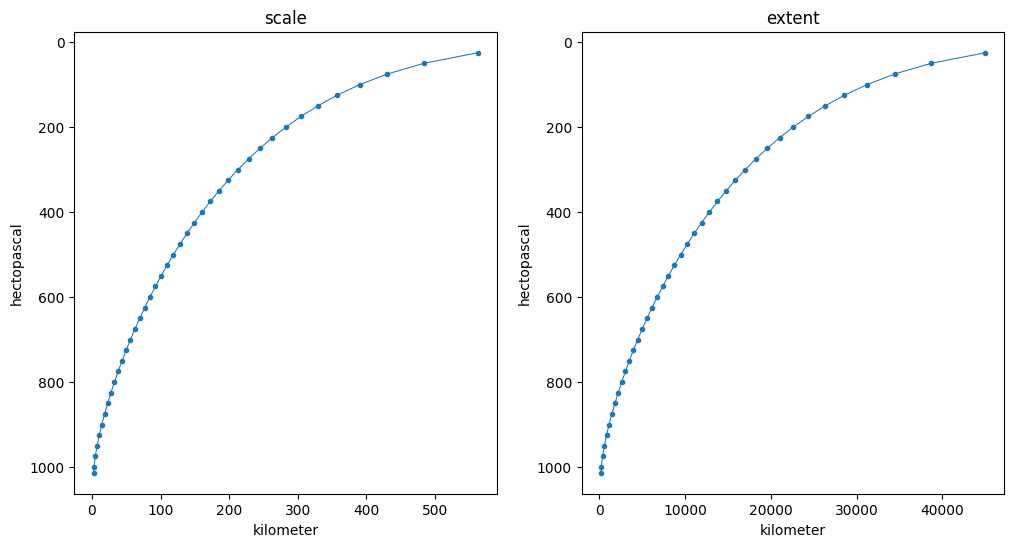

In [21]:
def create_dataframe(
    data: NDArray[float],
    # extent: NDArray[float],
    index: NDArray[float],
    s: float,
    e: float,
    ratio: NDArray[float] | float = 1.0,
    # ratio:float = 1.0,
    # columns: NDArray[float],
):
    return pd.DataFrame(
        dict(
            scale=create_scale(data, value=s, ratio=ratio),
            extent=create_scale(data, value=e, ratio=ratio),
        ),
        index=index,
        # columns=columns,
    )


scaled_extent = (
    create_dataframe(
        log_p(p_levels).magnitude[::-1],
        p_levels,
        s=URMA_GRID_SPACING,
        e=TARGET,
        ratio=pressure2height(p_levels).magnitude * 10,
        # columns=p_levels,
    )
    # .loc[[1013.25, 850, 700, 500, 300]]
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.invert_yaxis()
ax2.invert_yaxis()
Y = scaled_extent.index.to_numpy() * hPa
ax1.plot(scaled_extent["scale"].to_numpy() * km, Y, **plot_kwargs)
ax1.set_title("scale")
ax2.plot(scaled_extent["extent"].to_numpy() * km, Y, **plot_kwargs)
ax2.set_title("extent")
scaled_extent.loc[[1013.25, 850, 700, 500, 300]].sort_index()

NameError: name 'data_frame' is not defined

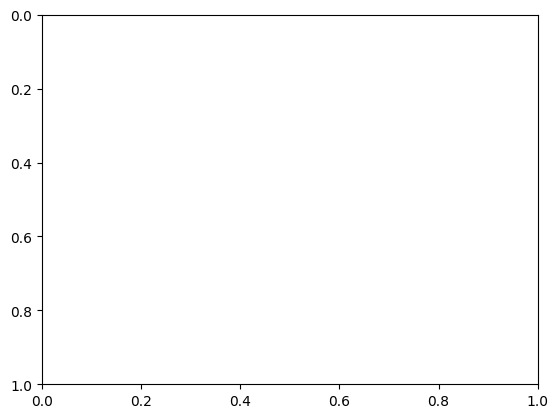

In [22]:
import pandas as pd

ax = plt.axes()
ax.invert_yaxis()

norm = X = (normalize(p_levels) + 1) * dimensionless  # type: ignore
scale = Y = normalize(log_p(p_levels))[::-1] + 1 * dimensionless  # type: ignore


df = data_frame(scale=scale, levels=p_levels)
df.plot.line(x="scale", y="levels", ax=ax, label="scale", **plot_kwargs)

df.iloc[::4]

In [ ]:
p_targets = quantity([1013.25, 850, 700, 500, 300], hPa)
mask = np.isin(p_levels, p_targets)  # type: ignore

scale[mask]

# (pressure2height(p_targets) * ((scale[mask] / 1.25) + 1) * 200)